## 对用户进行聚类
## 数据来源于 Kaggle 竞赛
## 竞赛官网：
### https://www.kaggle.com/c/event-recommendation-engine-challenge/data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

In [2]:
# 导入数据
user_data = pd.read_csv('./data/users.csv')
user_data.head()

,user_id,locale,birthyear,gender,joinedAt,location,timezone
0,3197468391,id_ID,1993,male,2012-10-02T06:40:55.524Z,Medan Indonesia,480.0
1,3537982273,id_ID,1992,male,2012-09-29T18:03:12.111Z,Medan Indonesia,420.0
2,823183725,en_US,1975,male,2012-10-06T03:14:07.149Z,Stratford Ontario,-240.0
3,1872223848,en_US,1991,female,2012-11-04T08:59:43.783Z,Tehran Iran,210.0
4,3429017717,id_ID,1995,female,2012-09-10T16:06:53.132Z,NaN,420.0


In [3]:
#user_id不作为聚类属性
user_id = user_data.user_id
user_data = user_data.drop(["user_id"], axis=1)

In [4]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38209 entries, 0 to 38208
Data columns (total 6 columns):
locale       38209 non-null object
birthyear    38209 non-null object
gender       38100 non-null object
joinedAt     38152 non-null object
location     32745 non-null object
timezone     37773 non-null float64
dtypes: float64(1), object(5)
memory usage: 1.7+ MB


可以看到有很多非数值型特征，还有很多特征有缺失值,特别是location太多缺失值了，直接丢弃

In [5]:
user_data = user_data.drop(["location"], axis=1)

In [6]:
user_data.locale.value_counts()

en_US    17073
id_ID    11817
es_LA     1999
en_GB     1745
es_ES      981
fa_IR      676
ar_AR      584
hu_HU      544
fr_FR      529
pt_BR      472
ka_GE      407
zh_CN      183
ru_RU      135
ja_JP      121
de_DE      119
tr_TR      109
ko_KR       91
it_IT       78
vi_VN       61
fr_CA       49
zh_TW       41
pt_PT       36
th_TH       27
km_KH       25
pl_PL       24
jv_ID       23
cs_CZ       22
sv_SE       22
el_GR       19
zh_HK       19
         ...  
hr_HR       11
bg_BG       11
nl_NL       10
he_IL        9
sk_SK        7
sr_RS        6
en_IN        5
mk_MK        4
nb_NO        4
fi_FI        4
bn_IN        4
ca_ES        4
da_DK        4
bs_BA        3
mn_MN        3
lt_LT        2
af_ZA        2
fb_LT        2
lv_LV        2
ku_TR        2
uk_UA        2
az_AZ        2
en_UD        2
et_EE        1
tl_PH        1
pa_IN        1
cy_GB        1
hi_IN        1
es_MX        1
eo_EO        1
Name: locale, Length: 64, dtype: int64

可以分析出这是一个无序分类特征，我们需要对其做编码处理

In [7]:
from collections import defaultdict
import locale

localeIdMap = defaultdict(int)
for i, l in enumerate(locale.locale_alias.keys()):
    localeIdMap[l] = i + 1

# 定义locale转换函数，后面循环调用
def getLocaleId(locstr):
    return localeIdMap[locstr.lower()]

In [8]:
user_data.birthyear.value_counts()

1993      3915
1992      3604
1994      3446
1990      3016
1991      2976
1995      2065
1989      1942
1996      1758
1988      1622
None      1492
1997      1331
1987      1255
1986      1086
1985       983
1980       856
1984       823
1983       717
1998       673
1982       626
1981       580
1979       453
1978       408
1977       359
1976       176
1975       168
1999       150
1971       120
1974       119
1972       108
1970       106
          ... 
1911         4
1907         4
1916         4
1915         4
1922         3
1928         3
1930         3
1943         3
1935         3
1917         3
1913         3
1933         3
1923         2
1938         2
1908         2
1914         2
1912         2
1924         2
1929         1
1903         1
1902         1
1932         1
1934         1
16-Mar       1
23-May       1
1909         1
1937         1
1927         1
1931         1
1921         1
Name: birthyear, Length: 98, dtype: int64

可以看到有很多None,还有23-May之类的数据，将这些数据记为Nan

In [9]:
user_data.birthyear = pd.to_numeric(user_data.birthyear,  errors='coerce')
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38209 entries, 0 to 38208
Data columns (total 5 columns):
locale       38209 non-null object
birthyear    36715 non-null float64
gender       38100 non-null object
joinedAt     38152 non-null object
timezone     37773 non-null float64
dtypes: float64(2), object(3)
memory usage: 1.5+ MB


再来对gender进行处理

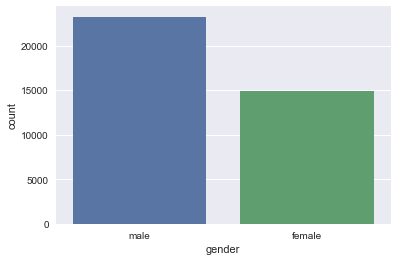

In [10]:
sns.countplot(user_data.gender)

转为数值1，2

In [11]:
genderIdMap = defaultdict(int, {'NaN': 0, "male":1, "female":2})

def getGenderId(genderStr):
    return genderIdMap[genderStr]

对joinedAt进行处理

In [12]:
import datetime

def getJoinedYearMonth(dateString):
    try:
        dttm = datetime.datetime.strptime(dateString, "%Y-%m-%dT%H:%M:%S.%fZ")
        return (dttm.year-2010)*12 + dttm.month
    except:  #缺失补0
        return 0

In [13]:
def getBirthYearInt(birthYear):
    #缺失补0
    try:
        return 0 if birthYear == 'None' else int(birthYear)
    except:
        return 0

def getTimezoneInt(timezone):
    try:
        return int(timezone)
    except:  #缺失值处理
        return 0

In [14]:
from sklearn.preprocessing import normalize

cols = ['LocaleId', 'BirthYearInt', 'GenderId', 'JoinedYearMonth', 'TimezoneInt']
n_cols = len(cols)
userMatrix = np.zeros((user_data.shape[0],n_cols), dtype=np.int)

for i in range(user_data.shape[0]): 
    userMatrix[i, 0] = getLocaleId(user_data.loc[i,'locale'])
    userMatrix[i, 1] = getBirthYearInt(user_data.loc[i,'birthyear'])
    userMatrix[i, 2] = getGenderId(user_data.loc[i,'gender'])
    userMatrix[i, 3] = getJoinedYearMonth(user_data.loc[i,'joinedAt'])
    userMatrix[i, 4] = getTimezoneInt(user_data.loc[i,'timezone'])

# 归一化用户矩阵
userMatrix = normalize(userMatrix, norm="l1", axis=0, copy=False)

user_data_FE = pd.DataFrame(data=userMatrix, columns=cols)  

In [15]:
user_data_FE.head()

,LocaleId,BirthYearInt,GenderId,JoinedYearMonth,TimezoneInt
0,0.000036,0.000027,0.000019,0.000026,0.000036
1,0.000036,0.000027,0.000019,0.000026,0.000031
2,0.000020,0.000027,0.000019,0.000026,-0.000018
3,0.000020,0.000027,0.000038,0.000027,0.000016
4,0.000036,0.000027,0.000038,0.000026,0.000031


In [16]:
user_data_FE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38209 entries, 0 to 38208
Data columns (total 5 columns):
LocaleId           38209 non-null float64
BirthYearInt       38209 non-null float64
GenderId           38209 non-null float64
JoinedYearMonth    38209 non-null float64
TimezoneInt        38209 non-null float64
dtypes: float64(5)
memory usage: 1.5 MB


## 做完特征工程，开始做聚类，由于这个数据集的维数本来就很小了，故在此不对他进行降维

In [17]:
data_train, data_val = train_test_split(user_data_FE, train_size = 0.8,random_state = 0)

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [18]:
print(data_train.shape)
print(data_val.shape)

(30567, 5)
(7642, 5)


In [19]:
from sklearn.cluster import MiniBatchKMeans

n_clusters = [20, 40, 80]
user_data_Predict = user_data_FE
CH_scores = []
S_scores = []

for i,n_cluster in enumerate(n_clusters):
    km = MiniBatchKMeans(n_clusters = n_cluster)
    km.fit(data_train)
    
    #预测
    cluster_name = 'cluster_' + str(n_cluster)
    user_data_Predict[cluster_name] = km.predict(user_data_FE.iloc[:,:5])
    
    #评估
    S_score = metrics.silhouette_score(data_val, km.predict(data_val))
    S_scores.append(S_score)
    CH_score = metrics.calinski_harabaz_score(data_val, km.predict(data_val))
    CH_scores.append(CH_score)
    print("CH_score: {}".format(CH_score))
    print("S_score: {}".format(S_score))

CH_score: 8248.179121437626
S_score: 0.6830333987905183
CH_score: 7710.351068377943
S_score: 0.6818634336495453
CH_score: 6833.101324558472
S_score: 0.6109857049102416


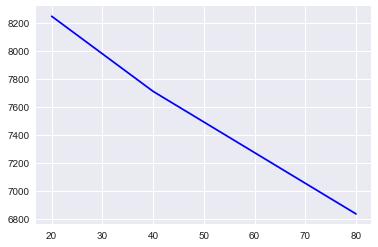

In [20]:
plt.plot(n_clusters, np.array(CH_scores), 'b-')

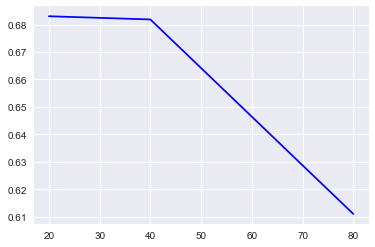

In [24]:
plt.plot(n_clusters, np.array(S_scores), 'b-')

In [21]:
user_data_Predict.head()

,LocaleId,BirthYearInt,GenderId,JoinedYearMonth,TimezoneInt,cluster_20,cluster_40,cluster_80
0,0.000036,0.000027,0.000019,0.000026,0.000036,4,1,62
1,0.000036,0.000027,0.000019,0.000026,0.000031,4,1,44
2,0.000020,0.000027,0.000019,0.000026,-0.000018,9,17,60
3,0.000020,0.000027,0.000038,0.000027,0.000016,16,11,18
4,0.000036,0.000027,0.000038,0.000026,0.000031,0,2,54


In [22]:
user_data_Predict.to_csv('users_MiniBatchKMeans_Pre.csv')

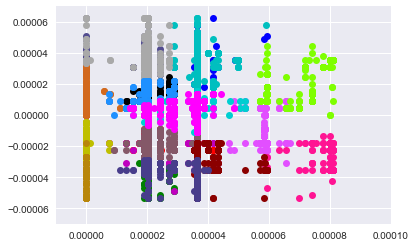

In [23]:
colors = ['b','g','r','k','c','m','y','#e24fff','#524C90','#845868','chartreuse','chocolate','darkgray','darkgoldenrod','darkturquoise','deeppink','dodgerblue','darkred','darkslateblue','fuchsia']

for i in range(20):
    part_of_preddict = user_data_Predict[user_data_Predict["cluster_20"] == i]
    x_data = part_of_preddict['LocaleId']
    y_data = part_of_preddict['TimezoneInt']
    plt.scatter(x_data,y_data,color=colors[i],linewidths=0.0001)

plt.axis([-0.00001,0.0001,-0.00007,0.00007])
plt.show()

可以看到分类效果还是不错